In [21]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import  os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential

from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [22]:
import string
import glob
import  os

In [23]:
# Read the caption file 
def load_doc(filename):
    #open the file as read only
    file = open(filename, 'r')
    #read all text
    text = file.read()
    #close the file
    file.close()
    return text

filename = "Flickr8k/Flickr8k_text/Flickr8k.token.txt"
doc = load_doc(filename)

print (doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [24]:
#save the captions under key-value type: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']

def load_description(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        tokens = line.split() #split by 'space'
        if len(line) < 2: # it should be tokens
            continue
        # take the first token as the image id, the rest as the description
        # tokens [1: ] is ['A', 'child',....., 'in', 'a', 'pink']
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        # merging the words in image_desc by space
        image_desc = ' '.join(image_desc)
        
        #create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        
        # store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_description(doc)
print ('Loaded: %d' %len(descriptions))


Loaded: 8092


In [25]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [26]:
# preprocessing text
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range (len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove puctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove token with number in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] = ' '.join(desc)
            
# clean description
clean_descriptions(descriptions)

In [27]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [28]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
save_descriptions(descriptions, 'description.txt')

In [29]:
# Load the tranining, test, and validation data 
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    #process line by line
    for line in doc.split('\n'):
        #skip empty lines
        if len(line) < 1:
            continue
        # gets image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load train data
filename = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
        

Dataset: 6000


In [30]:
# Folder pathname  of data set
images = 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
# get the jpg image in the directory
img = glob.glob(images + '*.jpg')

print (len(img))

8091


In [31]:
# train images file
train_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# create the list of the training images with their full path names

train_img = []
#img is list of full path names of all image
for i in img:
    # check if the img in the dataset folder is listed in trainImages.txt
    if i[len(images):] in train_images:
        train_img.append(i) # add it to the list of train image
print (len(train_img))


6000


In [32]:
# File chứa các id ảnh để test
test_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
        
print (len(test_img))

1000


In [33]:
# add 'startseq' and 'endseq' for the string
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        #split lin by white space
        tokens = line.split()
        # get the id and description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        
        if image_id in dataset:
            #create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            #wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            #store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('description.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
print (train_descriptions['1000268201_693b08cb0e'][0])

Descriptions: train=6000
startseq child in pink dress is climbing up set of stairs in an entry way endseq


In [34]:
# Load image with specific size required by Inception v3
def preprocess(image_path):
    # size 299x299
    img = image.load_img(image_path, target_size=(299, 299))
    # convert PIL image to numpy array for 3-dimensions
    x = image.img_to_array(img)
    # add one more dimension
    x = np.expand_dims(x, axis = 0)
    # preprocess the images using preprocessing_input()
    x = preprocess_input(x)
    return x

In [35]:
# Load the Inception v3 model
model = InceptionV3(weights='imagenet')

In [36]:
# eliminate the last Layer
model_new = Model(model.input, model.layers[-2].output)


In [37]:
# Image Embedding to vector(2048, )
def encode(image):
    image = preprocess(image) # preprocess
    fea_vec = model_new.predict(image) # get the encoding vector
    # reshape from (1, 2048) to (2048, )
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [38]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print ("Time taken in second =", time() - start)

Time taken in second = 610.8171262741089


In [39]:
# save image embedding
with open("Flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [40]:
# Encode test image
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 102.03181481361389


In [41]:
# Save the bottleneck test features to disk
with open("Flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [42]:
train_features = load(open("Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [43]:
# Create the list of training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

print (len(all_train_captions))

30000


In [44]:
# Chỉ lấy các từ xuất hiện trên 10 lần
# only the words appear > 10 times are used
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [45]:
print (vocab[1:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of']


In [46]:
lines = list()

for desc in vocab:
    lines.append(desc)

data = '\n'.join(lines)
file = open('vocab.txt', 'w')
file.write(data)
file.close()

In [47]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w  # index to word
    ix += 1

In [48]:
vocab_size = len(ixtoword) + 1 # 1 is added for padding
vocab_size

1652

In [49]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [50]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [51]:
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [52]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [53]:
embedding_matrix.shape

(1652, 200)

In [54]:
# Construct model
inputs1 = Input(shape=(2048,)) # embedded image input
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,)) # word embedding input 
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [55]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [56]:
print (model.layers[2].name)
# The Layer 2 uses GLOVE Model sp we just set the weight without training
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

embedding_1


In [57]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [58]:
model.optimizer.learning_rate = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [59]:
list_his = list()
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    history = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    list_his.append(history)

Epoch 1/1
1000/1000 [==============================] - 294s 294ms/step - loss: 5.1592
Epoch 1/1
1000/1000 [==============================] - 291s 291ms/step - loss: 4.4166
Epoch 1/1
1000/1000 [==============================] - 290s 290ms/step - loss: 4.0601
Epoch 1/1
1000/1000 [==============================] - 290s 290ms/step - loss: 3.8690
Epoch 1/1
1000/1000 [==============================] - 290s 290ms/step - loss: 3.7336
Epoch 1/1
1000/1000 [==============================] - 290s 290ms/step - loss: 3.6321
Epoch 1/1
1000/1000 [==============================] - 291s 291ms/step - loss: 3.5494
Epoch 1/1
1000/1000 [==============================] - 291s 291ms/step - loss: 3.4782
Epoch 1/1
1000/1000 [==============================] - 290s 290ms/step - loss: 3.4216
Epoch 1/1
1000/1000 [==============================] - 291s 291ms/step - loss: 3.3674


In [82]:
model.save_weights('./model_30.h5')

In [64]:
print (list_his[1].history['loss'])

TypeError: 'History' object is not subscriptable

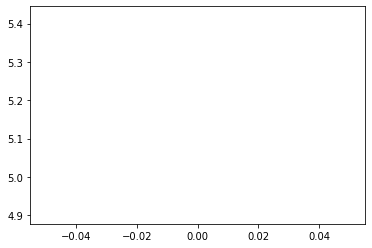

In [60]:
plt.plot(list_his[0].history['loss'])
plt.show()

In [16]:
images = 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'

In [18]:
from pickle import dump, load
with open("Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [98]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

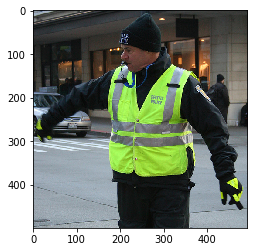

man in red shirt and black hat is walking down the street


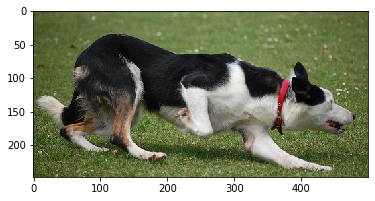

black and white dog is running through the grass


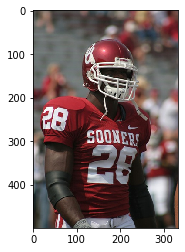

football player in the red jersey is wearing red and white jersey


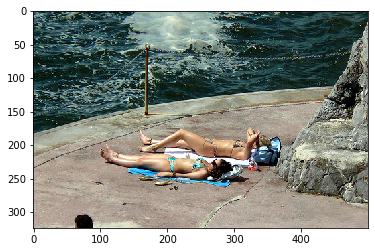

two girls are playing in the water


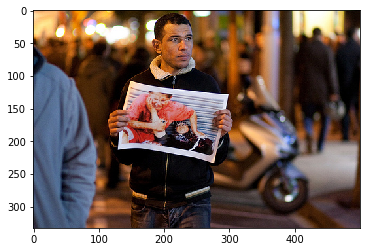

man in black shirt and black shirt is standing on the street


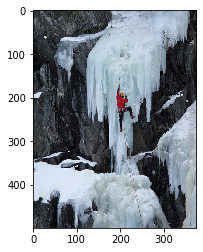

man in red shirt is standing on the edge of the snow


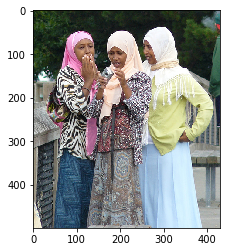

woman in red shirt and white hat is standing in front of the street


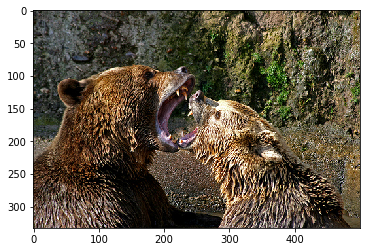

dog is running through the water


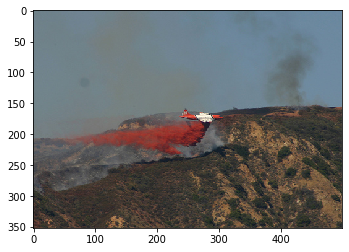

man with red shirt is standing on the top of the ocean


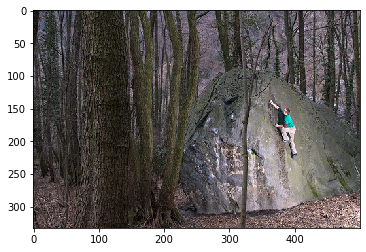

man is climbing rock cliff


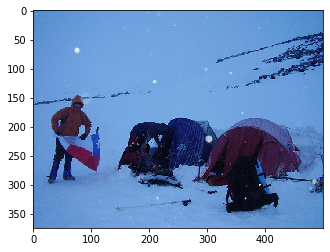

two people are sitting on the snow


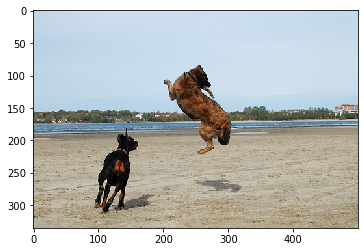

dog is running on the beach


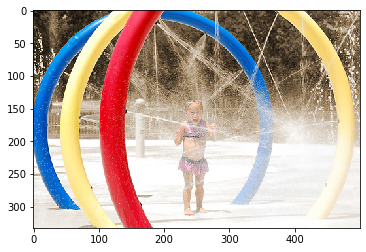

the girl is sitting on the water


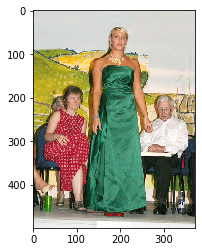

two girls are sitting on the street


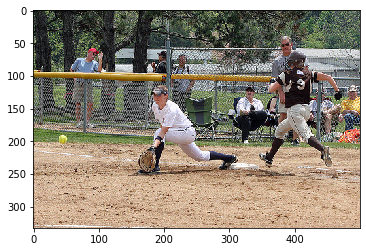

boy in red shirt is playing on the grass


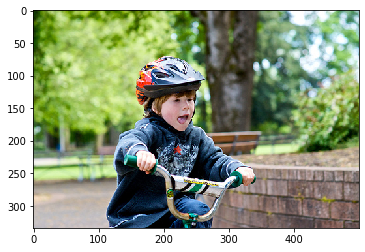

man wearing red shirt is riding bike on the street


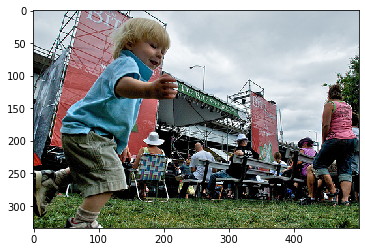

man in red shirt and white shirt is walking on the sidewalk


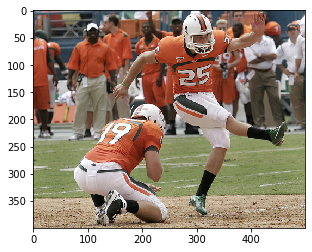

two football players in the field


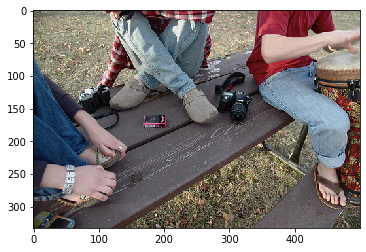

man in white shirt is sitting on bench


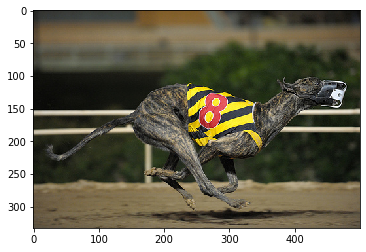

dog is running through the grass


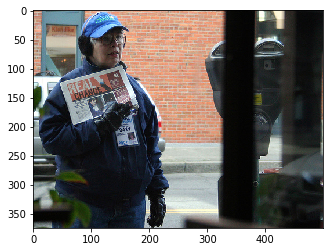

man in black hat and black hat is standing in front of building


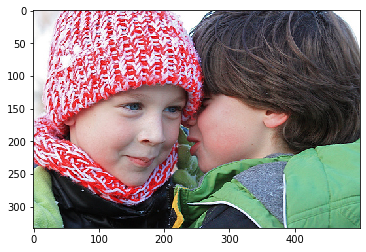

woman in red shirt is holding her head


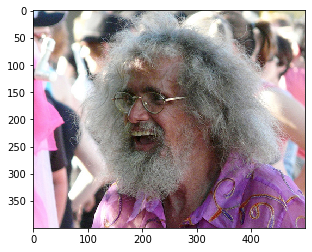

man with red hair and black hair is standing in front of crowd


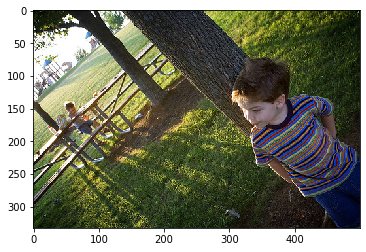

little boy in red shirt is jumping on the grass


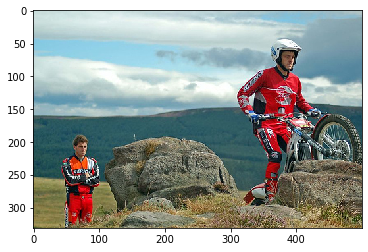

man in red shirt and helmet is riding bike


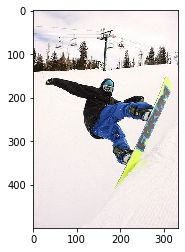

man in red jacket is skiing down the snow


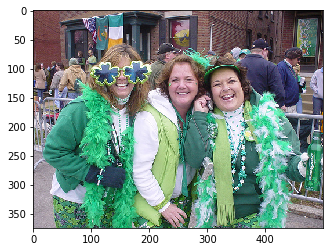

two women in dresses are standing in front of the street


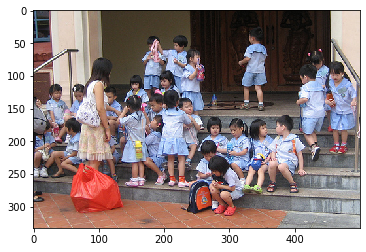

group of children are sitting on the street


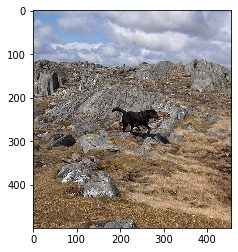

dog is walking on the beach


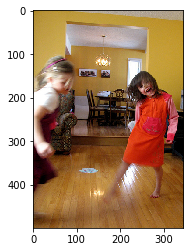

little girl in pink shirt is standing on the floor


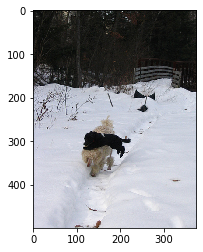

two dogs play in the snow


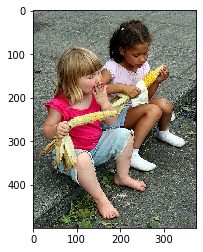

little girl in pink shirt is sitting on the grass


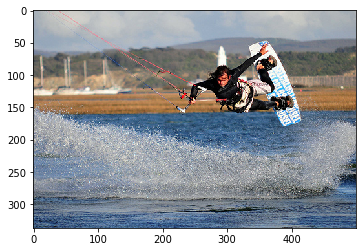

man in red shirt is riding on the water


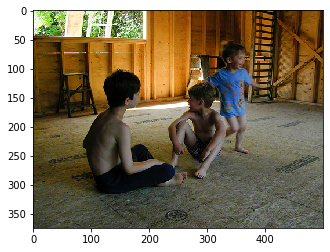

boy is jumping into the water


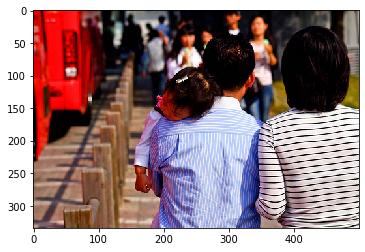

man in black shirt and black shirt is standing on the street


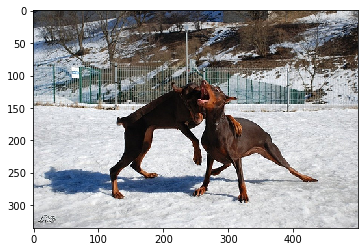

brown dog is running through the grass


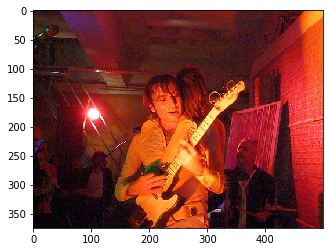

man in black shirt and white shirt is standing on the grass


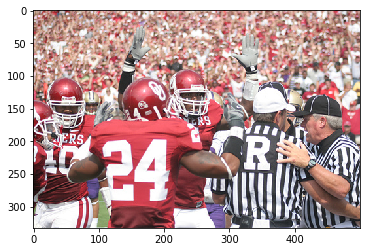

football player in the red and white and white jersey is running on the ground


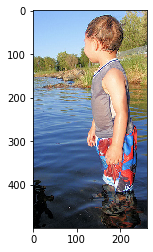

boy in bathing trunks is walking on the beach


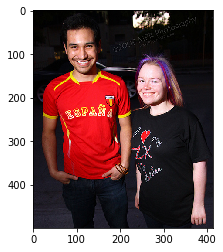

two young girls are posing for picture


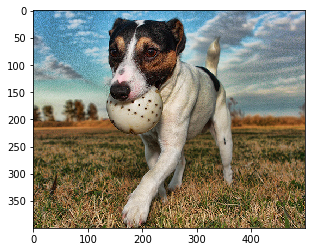

dog is running through the grass


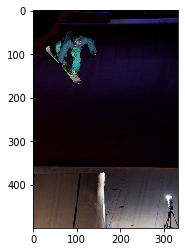

the skateboarder is jumping over the trampoline


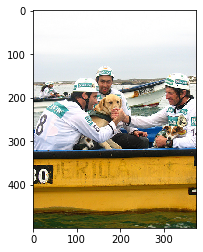

man in red shirt and white hat is sitting on the street


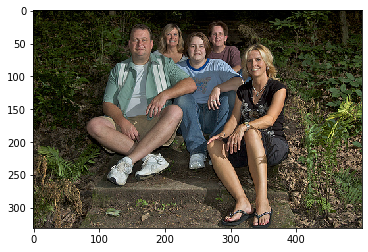

two boys sit on the top of the rocks


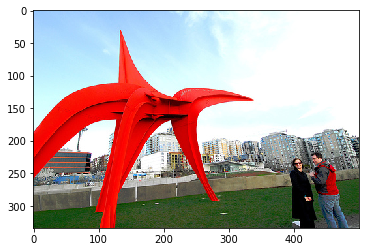

man in red shirt is standing on the sidewalk


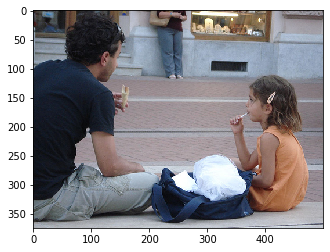

two children sit on the sidewalk


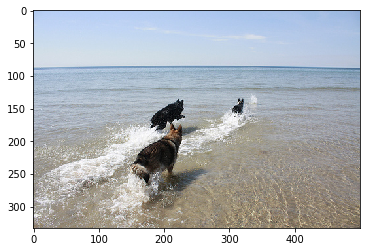

dog running through the water


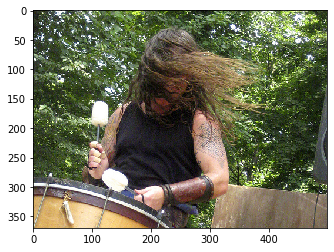

man in red shirt is standing in front of the water


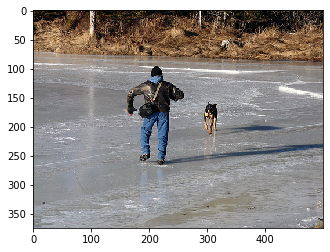

two dogs are running through the water


In [116]:
for z in range(1, 50):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print(greedySearch(image))

In [ ]:
testgenerator = data_generator(, train_features, 
                               wordtoix, max_length, number_pics_per_bath)


In [11]:
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras import Input, layers
from keras.layers.merge import add

max_length = 34
vocab_size = 1652
embedding_dim = 200

# Construct model
inputs1 = Input(shape=(2048,)) # embedded image input
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,)) # word embedding input 
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [13]:
model.load_weights("./model_30.h5")

In [64]:
filename = "vocab.txt"
doc = load_doc(filename)
vocab = doc.split('\n')

print (vocab[0:10])

['startseq', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of']


In [59]:
ixtoword = {}
wordtoix = {}
ix = 1

for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w  # index to word
    ix += 1

In [76]:
from keras.preprocessing.sequence import pad_sequences

In [77]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

(2048,)


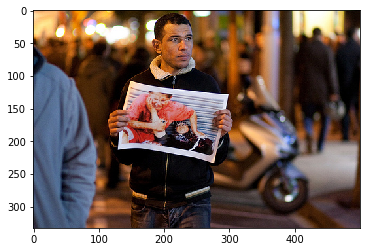

man in black shirt and black shirt is standing on the street


In [81]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
z = 5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))


In [82]:
print (image)

[[0.37398973 0.8028838  0.19388768 ... 0.21752805 0.3835187  0.27266738]]
